In [1]:
!pip install kaggle

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [3]:
!kaggle datasets download -d gti-upm/leapgestrecog -p /content/

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.13G/2.13G [00:24<00:00, 144MB/s]
100% 2.13G/2.13G [00:24<00:00, 92.5MB/s]


In [4]:
!unzip /content/leapgestrecog.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: /

In [5]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Step 1: Set Dataset Path
data_dir = '/content/leapGestRecog'  # Adjust this path if needed

In [6]:
# Step 2: Load and Preprocess Dataset using ImageDataGenerator
def load_dataset(data_dir):
    image_size = (299, 299)

    # Define the ImageDataGenerator with data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=20,  # Random rotation
        width_shift_range=0.2,  # Horizontal shift
        height_shift_range=0.2,  # Vertical shift
        zoom_range=0.2,  # Random zoom
        horizontal_flip=True,  # Horizontal flip
        validation_split=0.3
    )

    # Training data generator
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    # Validation data generator
    val_datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.3)
    validation_generator = val_datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator


In [7]:
# Step 3: Build Xception Model with Transfer Learning
def build_xception_model(num_classes):
   # Load the pre-trained Xception model without the top layers
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    # Unfreeze the top layers for fine-tuning
    for layer in base_model.layers[:-30]:  # Freeze all layers except the top 30
        layer.trainable = False

    for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
        layer.trainable = True

    # Add custom layers for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global average pooling
    x = Dropout(0.4)(x)              # Dropout for regularization
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with a lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [17]:
# Step 4: Train the Model
def train_model(model, train_generator, validation_generator):
    # Add callbacks for learning rate reduction and early stopping
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]

    # Train the model
    history = model.fit(
        train_generator,
        epochs=6,
        validation_data=validation_generator,
        callbacks=callbacks
    )
    return history


In [19]:
def evaluate_model(model, validation_generator):
    val_labels = []
    val_preds = []

    # Predict on the validation data
    for images, labels in validation_generator:
        preds = model.predict(images)
        val_labels.extend(np.argmax(labels, axis=1))  # True labels
        val_preds.extend(np.argmax(preds, axis=1))    # Predicted labels

        if len(val_labels) >= validation_generator.samples:
            break

    # Confusion Matrix
    cm = confusion_matrix(val_labels, val_preds)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    print("Classification Report:\n", classification_report(val_labels, val_preds))

    # ROC and AUC
    val_probs = model.predict(validation_generator)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(validation_generator.num_classes):
        fpr[i], tpr[i], _ = roc_curve([1 if label == i else 0 for label in val_labels], val_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(validation_generator.num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    return cm


In [ ]:
train_gen, val_gen = load_dataset(data_dir)

# Build the model
model = build_xception_model(num_classes=train_gen.num_classes)

# Train the model
history = train_model(model, train_gen, val_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

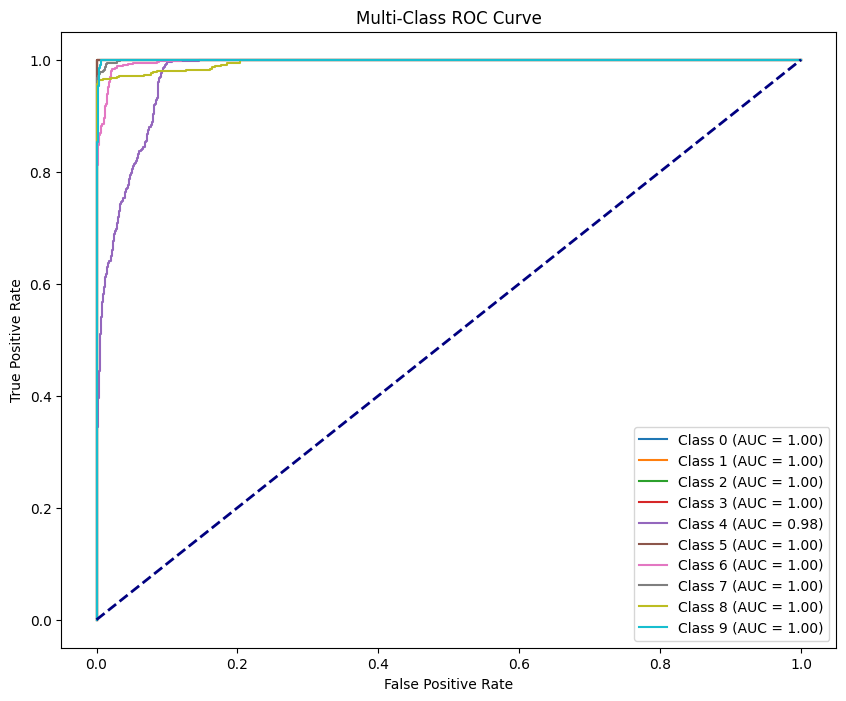

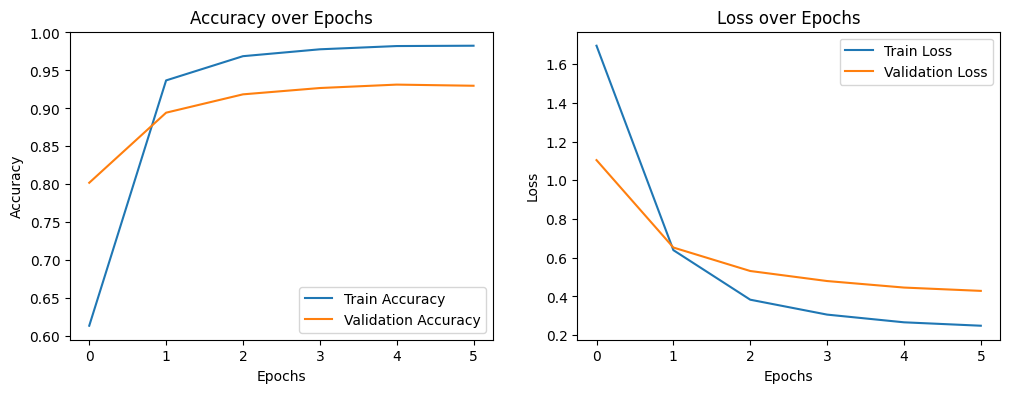

In [20]:
# Evaluate the model
evaluate_model(model, val_gen)

# Plot Accuracy and Loss over Epochs
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# Define the path to save the model
model_save_path = '/content/drive/My Drive/Xception_model/Xception_model.h5'

# Save the model
model.save(model_save_path)
print(f"Model saved to Google drive")


Model saved to Google drive
